In [32]:
# Imports
%matplotlib notebook
# numpy, matplotlib, seaborn and matplotlib
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# define data path
INPUT_PATH = "../data/%s.csv"
# define small samples to quickly explore data
read_rows = 300;

# Dataset Visualization Part

## Overview Part
This part is to overview the first N rows of the sample to get initial feeling of the dataset

In [ ]:
# load data head for overview
train_date_overview = pd.read_csv('../data/train_date.csv',nrows = read_rows)
train_categorical_overview = pd.read_csv('../data/train_categorical.csv',nrows = read_rows)
train_numeric_overview = pd.read_csv('../data/train_numeric.csv',nrows = read_rows)
test_categorical_overview = pd.read_csv('../data/test_categorical.csv', nrows = read_rows)
test_date_overview = pd.read_csv('../data/test_date.csv', nrows = read_rows)
test_numeric_overview = pd.read_csv('../data/test_numeric.csv', nrows = read_rows)

In [ ]:
#train_numeric_overview
#train_categorical_overview
train_date_overview
#test_numeric_overview
#test_categorical_overview
test_date_overview 

## General Feature Exploration Part
This part is to explore the common feature

In [ ]:
# function to calculate failure rate
def get_failure_rate(file_name):
    # will calculate the error rate from data on the file based on response col
    # Respons: 1 = Failed QC , 0 = Passed QC
    rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Response"])
    failure_rate = rows[rows.Response == 1].size / float(rows[rows.Response == 0].size)
    return failure_rate

In [ ]:
# function to calculate data size in 6 dataset
def explore_data_size():
    # explore the size (rows, cols) of each file
    data_files = ['train_numeric', 'train_date', 'train_categorical', 'test_numeric',
                  'test_date', 'test_categorical']
    stats = []
    for file_name in data_files:
        cols = pd.read_csv(INPUT_PATH % file_name, nrows=1)
        rows = pd.read_csv(INPUT_PATH % file_name, usecols=["Id"])
        stats.append({'File': file_name, 'Rows': rows.shape[0], 'Columns': cols.shape[1]})
    # convert the result into a DataFrame so we can do plotting.
    df = pd.DataFrame(stats, columns=["File", "Rows", "Columns"])
    failure_rate = get_failure_rate('train_numeric')
    df["Error"] = 0
    df.loc[df.File == 'train_numeric', 'Error'] = failure_rate
    return df

In [ ]:
# Get data size
explore_data_size()

## Numerical Feature Exploration Part

In [ ]:
def get_number_features(station_features):
    total_features = 0
    for key in station_features.keys():
        total_features += len(station_features[key]) 
    return total_features

def get_features(feature_list):
    # function to group features by station or line of production the convention is:
    # L1_S15_F232 means Line 1, Station 15, Feature 232
    line_features = {}
    station_features = {}
    lines = set([item.split('_')[0] for item in feature_list])
    stations = set([item.split('_')[1] for item in feature_list])

    for l in lines:
        line_features[l] = [item for item in feature_list if '%s_' % l in item]

    for s in stations:
        station_features[s] = [item for item in feature_list if '%s_' % s in item]
    
    print 'No. of lines: '+ str(len(lines))
    print 'No. of stations: '+ str(len(stations))
    print 'No. of features: '+ str(int(get_number_features(station_features)))
    

    return (line_features, station_features)

In [ ]:
def explore_features(data_set_name,is_response):
    # how many units processed in each station
    # also percentage of failed/passed QS in each station
    if is_response :
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    else:
        features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Id"], axis=1).columns.values
    
    line_features, station_features = get_features(features)
    # create a dataframe cols: station, features_count
    sdf = pd.DataFrame(list({int(key[1:]): len(station_features[key]) for
                             key in station_features.keys()}.items()),
                       columns=["Station", "FeatureCount"])
    ldf = pd.DataFrame(list({int(key[1:]): len(line_features[key]) for
                             key in line_features.keys()}.items()),
                       columns=["Line", "FeatureCount"])
    
    stations_plot = sdf.plot(x="Station", y="FeatureCount", kind="bar",
                             title="Fig.1 - Features by Station",
                             figsize=(13,6), fontsize=12)
    
    line_features_plot = ldf.plot(x="Line",y="FeatureCount", kind="bar",
                             title="Fig.2 - Features by line",
                             figsize=(13,6), fontsize=12)
    
    #print 'No. of features:'+ str(int(get_number_features(station_features)))
    
    return line_features, station_features

In [ ]:
lf, sf = explore_features("train_numeric""train_numeric",True)

This part is to see how many parts per station, how many success and failure parts per station

In [ ]:
def explore_product_by_station(data_set_name,read_rows):
    # need to see how many product per station
    # features = pd.read_csv(INPUT_PATH % data_set_name, nrows=1).drop(["Response", "Id"], axis=1).columns.values
    # line_features, station_features = get_features(features)
    station_features = sf
    dwb_result = []
    ppbs_result = []
    rows = 0
    # inside this loop we will try to calculate different data sets, this way we only read the
    # files once since it takes a while and produce multiple results
    for station in station_features:
        station_data = pd.read_csv(
            INPUT_PATH % data_set_name,
            usecols=station_features[station] + ['Id', 'Response'],nrows = read_rows)
        
        # need to get how many rows in the sample row
        if not rows:
            rows = station_data.shape[0]
        # need to store how many processed units in each station
        # only if all features in that station has value we conside unit processed in this station
        ppbs_result.append(
            {'Station': int(station[1:]),
             'Processed': station_data[station_features[station]].notnull().all(axis=1).sum()})
        
        # data without blanks (dwb): take all rows and drop any row that has any blank
        # in any station column
        dwb = station_data.dropna(how="any")
        dwb_result.append([int(station[1:]), dwb.shape[0],
                       dwb[dwb["Response"] == 1].shape[0],
                       dwb[dwb["Response"] == 0].shape[0]])
        
    # convert list to a dataframe and prepare for the plot
    dwb_df = pd.DataFrame(
        dwb_result, columns=["Station", "Count", "Failed", "Passed"]).sort_values(by=["Station"])
    # calculate the error rate for each station
    dwb_df["Error"] = dwb_df.apply(lambda row: float(row["Failed"]) / (row["Count"] + 1), axis=1)
    
    # plot the stacked bar tot product/ station
    my_plot = dwb_df[["Station", "Failed", "Passed"]].plot(kind="bar", stacked=True, x="Station",
        title="Fig:3 - Products by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Record Count")
    
    # plot error rate per station
    my_plot = dwb_df[["Station", "Error"]].plot(
        kind="bar", x="Station",
        title="Fig:4 - Error by station", figsize=(13,6), fontsize=12)
    my_plot.set_xlabel("Stations")
    my_plot.set_ylabel("Error %")
    
    # process the ppbs result to see how many products has been process by each station.
    ppbs_df = pd.DataFrame(
        ppbs_result, columns=['Station', 'Processed']).sort(columns=['Station'])
    # calculate the missed product for each station: all count - processed count
    ppbs_df["Missed"] = ppbs_df["Processed"].apply(lambda x: rows - x)
    # the plot
    ppbs_df.plot(x="Station", kind="bar", stacked=True,
            title="Fig: 5 - Products processed by each station",
            figsize=(13,6), fontsize=12)
    



In [ ]:
explore_product_by_station("train_numeric",300)

## Categorial Data Exploration Part

In [ ]:
lf, sf = explore_features("train_categorical",False)

In [ ]:
# this function is to explore sparsity rate per row
def explore_sparse_rate(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % data_set_name,nrows = read_rows).drop(["Id"], axis=1)
    sparse_rate_each_part = []
    sparse_rate_series = train_categorical.isnull().sum(axis = 1)/train_categorical.shape[1]
    sparse_rate_df = pd.DataFrame(
        sparse_rate_series, columns=['sparse_rate'])
    return sparse_rate_df

In [ ]:
explore_sparse_rate('train_categorical', 100)

In [ ]:
# This function is to get feeling of the TX value in the dataset
def explore_dintinct_Tx_value(data_set_name, read_rows):
    train_categorical = pd.read_csv(INPUT_PATH % 'train_categorical',nrows = read_rows)
    del train_categorical['Id']
    train_categorical_zeroes = train_categorical.fillna(0)
    train_categorical_zeroes = train_categorical_zeroes.values 
    return np.unique(train_categorical_zeroes[train_categorical_zeroes!=0.0])

In [ ]:
explore_dintinct_Tx_value('train_categorical', 30)

# Feature Enginnering Part

## Method 1 : Applying PCA for Dimension Reduction
Preliminary work to search for appropriate n component
benchmark: how many variance is explained or we maintain how much variance

In [2]:
# import additional pakage
import math
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn import preprocessing
# define chunksize how many rows load one time
chunksize  = 50000

In [3]:
# Getting the column headers from first rows
# Reading as float32 to save Memory 
data = pd.read_csv(INPUT_PATH % 'train_numeric',nrows=1)
float_cols = [c for c in data]
float32_cols = {c: np.float32 for c in float_cols}

In [4]:
# define the number of pc for preliminary decomposition
n_components = 968
predictors = [x for x in data.keys() if (x != 'Response' and x != 'Id')]

In [5]:
def standard_feature_scaling(df):
    std_scale = preprocessing.StandardScaler().fit(df)
    df_std = pd.DataFrame(std_scale.transform(df))
    df_std.columns = df.columns
    df_std.index = df.index
    return df_std

In [6]:
def mean_imputer(DF):
    fill_NaN = preprocessing.Imputer(missing_values=np.nan, strategy='mean')
    imputed_DF = pd.DataFrame(fill_NaN.fit_transform(DF))
    imputed_DF.columns = DF.columns
    imputed_DF.index = DF.index
    return imputed_DF

In [ ]:
ipca = IncrementalPCA(n_components=968)
# Due to the large dataset read data seperately in chunks and perform IncrementalPCA 
counter = 0
for chunk in pd.read_csv(INPUT_PATH % 'train_numeric', chunksize=chunksize,dtype=float32_cols):
    counter += chunksize
    print ('processed',counter,'samples')
# To do: what value to fill NA 
    imputed_chunk = chunk[predictors].fillna(0.09)
    #imputed_chunk = mean_imputer(chunk[predictors])
    scailed_chunk = standard_feature_scaling(imputed_chunk)
#    chunk  = scailed_chunk.fillna(0)
    ipca.partial_fit(scailed_chunk)
print ('Number of Samples Seen:',ipca.n_samples_seen_ )


In [8]:
def get_explained_variance(pca_components):
    #print ('Explained variance by %d PCs:' %pca_components, np.sum(ipca.explained_variance_ratio_[:pca_components]))
    return np.sum(ipca.explained_variance_ratio_[:pca_components])

In [ ]:
# plot how many variance is explained based on how many n_components
n_components_value = range(968)
n_components_explained_variance = [get_explained_variance(x) for x in n_components_value]
explained_variance_pd = pd.DataFrame(n_components_explained_variance, columns=['explained_variance_rate'])
my_plot = explained_variance_pd.plot(title="explained_variance_rate", figsize=(10,6), fontsize=12)
my_plot.set_ylabel("Explained Variance Rate")
my_plot.set_xlabel("Number of Component")
n_components_explained_variance

In [ ]:
# Make Train DataFrame only with n PC 
PC_n = ['f'+str(x) for x in range(0,n_components)]
date_final = pd.DataFrame(columns=PC_n)
for cat in pd.read_csv(INPUT_PATH % 'train_numeric', chunksize=chunksize,dtype=float32_cols):
        cat  = cat.fillna(999)
        y=ipca.transform(cat[predictors])
        temp = cat['Id'].to_frame()
        for i in PC_n:
            temp[i]=0
        temp[PC_n]=y
        date_final = date_final.merge(temp, how='outer')
print (date_final)
date_final['Id'] = date_final['Id'].astype(np.int32)
# save new dataset to CSV file 
train_filename = 'train_numeric_SVD_%s.csv' % n_components
#date_final.to_csv(INPUT_PATH % train_filename,index=0)

In [ ]:
# Make Test DataFrame only with n PC 
PC_n = ['f'+str(x) for x in range(0,n_components)]
date_final = pd.DataFrame(columns=PC_n)
for cat in pd.read_csv('../input/test_numeric.csv', chunksize=chunksize,dtype=float32_cols):
        cat  = cat.fillna(999)
        y=ipca.transform(cat[predictors])
        temp = cat['Id'].to_frame()
        for i in PC_n:
            temp[i]=0
        temp[PC_n]=y
        date_final = date_final.merge(temp, how='outer')
date_final['Id'] = date_final['Id'].astype(np.int32)
test_filename = 'test_numeric_SVD_%s.csv' % n_components
# Save dataset to CSV file
#date_final.to_csv(INPUT_PATH % test_filename,index=0)

## Method 2 : XGBoost to select important features

In [22]:
# import additional package
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold

In [4]:
# Sample the data in a roundabout way to get 5 percent sample
date_chunks = pd.read_csv("../data/train_date.csv", index_col=0, chunksize=10000, dtype=np.float32)
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0,
                         usecols=list(range(969)), chunksize=10000, dtype=np.float32)
df_train = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.05)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
y_sample = pd.read_csv("../data/train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[df_train.index].values.ravel()
x_sample = df_train.values

In [5]:
#TODO fit y ravel or not?
clf = XGBClassifier(base_score=0.005)
clf.fit(x_sample, y_sample)

XGBClassifier(base_score=0.005, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

<IPython.core.display.Javascript object>


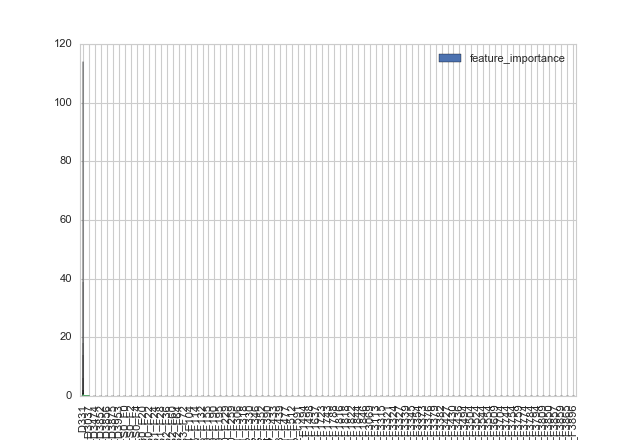

In [6]:
# create important feature dataframe and plot
fea_importance = pd.DataFrame(clf.feature_importances_)
fea_importance.index = df_train.columns
fea_importance.columns=["feature_importance"]
fea_importance_new = fea_importance[fea_importance.feature_importance >0.005]
fea_importance_new.plot(kind="bar")

In [7]:
# threshold for a manageable number of features
plt.hist(clf.feature_importances_[clf.feature_importances_>0])
important_indices = np.where(clf.feature_importances_>0.005)[0]
print(important_indices)

[  89  805  939 1018 1019 1029 1056 1156 1157 1158 1166 1167 1168 1169 1171
 1177 1178 1180 1188 1190 1194 1201 1208 1209 1215 1221 1231 1234 1237 1245
 1248 1259 1272 1274 1283 1290 1305 1476 1477 1502 1516 1520 1529 1537 1538
 1540 1549 1550 1843 1847 1879 1881 1882 1883 1887 1889 1892 1897 1898 1899
 1900 1911 1912 1914 1932 1934 1938 1942 1944 1955 1974 1982 1984 1985 1988
 1990 1992 1995 2004 2006 2007 2010 2022]


In [8]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X = np.concatenate([
    pd.read_csv("../data/train_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values
], axis=1)

y = pd.read_csv("../data/train_numeric.csv", index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

In [12]:
train_feature = pd.DataFrame(X)

In [17]:
# put important feature in the dataframe 
train_feature.columns = fea_importance_new.index
#end of feature selection

# Model Development 

## Model 1 : XGBoost

In [34]:
# self-defined xgb model wrapper including data processing, model fit, predict and result 
def modelfit(alg, dtrain, labels,useTrainCV=False, model_fit=True,model_predict=True,cv_folds=5, early_stopping_rounds=20):
    # trainCV with early stop so we don't need to use sciki-learn GridsearchCV , the later can't run in my computer
    best_threshold = 0.5
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=labels)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    if model_fit:
    #Fit the algorithm on the data
        alg.fit(dtrain.values, labels,eval_metric='auc')
        print ("fit done")
    if model_predict:
    #Predict training set:
    #dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain.values)[:,1]
        thresholds = np.linspace(0.01, 0.99, 50)
        mcc = np.array([matthews_corrcoef(labels, dtrain_predprob>thr) for thr in thresholds])
        plt.plot(thresholds, mcc)
        best_threshold = thresholds[mcc.argmax()]
        print(mcc.max())
    return best_threshold
    #Print model report:
#     print ("\nModel Report")
#     print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
#     print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

### Model Hyper-Parameter Tuning Part

In [31]:
# this part is for hyper-parameter tuning, but limited by my computer, 
# I can't run out of the result with gridsearchCV so instead i'm using cv
# provided by xgboost


NameError: name 'thresholds' is not defined

<IPython.core.display.Javascript object>


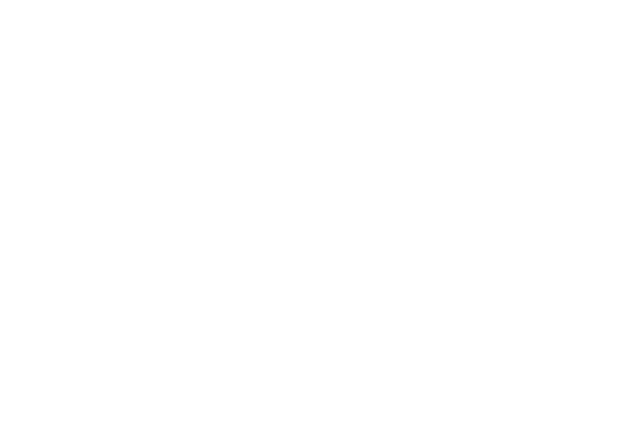

0.231748440824


In [35]:
xgb_starter = XGBClassifier(
 learning_rate =0.01,
 n_estimators=10,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 base_score=0.005)

best_threshold = modelfit(xgb_starter, train_feature, y)


# load test data, predict labels and submit

In [26]:
# load test data
test_feature = np.concatenate([
    pd.read_csv("../data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("../data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

In [27]:
# generate predictions at the chosen threshold
preds = (xgb_starter.predict_proba(test_feature)[:,1] > best_threshold).astype(np.int8)

In [28]:
# and submit
sub = pd.read_csv("../data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")

In [ ]:
#import additional library
from xgboost.sklearn import XGBClassifier

In [ ]:
#load data nearly same as previous section
#TODO: need refractor so that all code is consistent
# define Idcol and Response Column
IDcol = "Id"
target = "Response"
# Sample the data to decide some important features
start_time = datetime.datetime.now()
date_chunks = pd.read_csv("../data/train_date.csv", index_col=0, chunksize=chunksize, dtype=np.float32)
num_chunks = pd.read_csv("../data/train_numeric.csv", index_col=0, chunksize=chunksize, dtype=np.float32)
train_value = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.001)
               for dchunk, nchunk in zip(date_chunks, num_chunks)])
end_time = datetime.datetime.now()
print (end_time - start_time)

In [ ]:
# self-defined xgb model wrapper including data processing, model fit, predict and result 
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    # trainCV with early stop so we don't need to use sciki-learn GridsearchCV , the later can't run in my computer
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
#Choose all predictors except target & IDcols
predictors = [x for x in train_value.columns if x not in [target, IDcol]]
xgb_starter = XGBClassifier(
 learning_rate =0.01,
 n_estimators=2000,
 max_depth=10,
 min_child_weight=1,
 gamma=0,
 subsample=1,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 base_score=0.005)
modelfit(xgb_starter, train_value, predictors)

In [ ]:
### Train and prediction part

In [ ]:
clf = XGBClassifier(max_depth=5, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
preds = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    preds[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:,1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], preds[test])))
print(roc_auc_score(y, preds))

In [ ]:
# pick the best threshold by MCC
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [ ]:
# load test data
X = np.concatenate([
    pd.read_csv("../data/test_date.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices<1156]+1])).values,
    pd.read_csv("../data/test_numeric.csv", index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices>=1156] +1 - 1156])).values
], axis=1)

In [ ]:
# generate predictions at the chosen threshold
preds = (clf.predict_proba(X)[:,1] > best_threshold).astype(np.int8)

In [ ]:
# and submit
sub = pd.read_csv("../data/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")